In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

from desc.backend import jnp
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid, LinearGrid
import desc.io
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile

np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.1+103.g9ade1e3.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 10.98 GB available memory


## Visualizing different grids

In [3]:
rng = np.random.default_rng()
L = rng.integers(low=1, high=30)
M = rng.integers(low=1, high=30)
N = rng.integers(low=1, high=30)
NFP = rng.integers(low=1, high=30)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)

In [4]:
def print_grid(grid, stop=None, quantity=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    quantity : ndarray
        A quantity to print alongside the grid. i.e. data["iota"]
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    if quantity is None:
        for i, e in enumerate(zip(grid.nodes, grid.spacing)):
            a, b = e
            print(a, b)
            if i > stop:
                break
    else:
        for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
            a, b, c = e
            print(a, b, c)
            if i > stop:
                break

In [5]:
# print_grid(random_grid, stop=50)

In [6]:
def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,  # to avoid known grid bug
        sym=False,
        node_pattern=eq.node_pattern,
    )


def get_linear_grid(eq, rho):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    rho: ndarray
        Grid rhos.

    Returns
    -------
    LinearGrid
        LinearGrid grid for the given equilibrium.
    """
    return LinearGrid(
        M=max(1, eq.M_grid),
        N=max(1, eq.N_grid),
        NFP=1,  # to avoid known grid bug
        sym=False,
        rho=jnp.atleast_1d(rho),
    )


def get_vmec_plot(name):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    f = Dataset("edu-vmec/input-current/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
    return rho, iota


def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            yscale="symlog",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title=prepend_title + " iota" + append,
            facecolor="white",
        )
        ax[i].grid()


def plot_overlay(x, y, prepend_title, x2, y2, prepend_title_2, dpi=200):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 2 if len(x) > 128 else 5
    y = np.atleast_2d(y)
    y2 = np.atleast_2d(y2)
    fig, ax = plt.subplots(dpi=dpi)
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size, label=prepend_title)
        ax[i].plot(x, y[i, :])
        ax[i].scatter(x2, y2[i, :], s=dot_size, label=prepend_title_2)
        ax[i].plot(x2, y2[i, :])
        ax[i].set(
            yscale="log",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title="iota" + append,
            facecolor="white",
        )
        ax[i].grid()
    fig.legend()

3 26 13 11 True jacobi
2 44 27
nodes               spacing
[0.355 0.081 0.000] [1.678 0.676 0.059] -0.0
[0.355 0.322 0.000] [1.678 0.676 0.059] -0.0
[0.355 0.564 0.000] [1.678 0.676 0.059] -0.0
[0.355 0.806 0.000] [1.678 0.676 0.059] -0.0
[0.355 1.047 0.000] [1.678 0.676 0.059] -0.0
[0.355 1.289 0.000] [1.678 0.676 0.059] -0.0
[0.355 1.531 0.000] [1.678 0.676 0.059] -0.0
[0.355 1.772 0.000] [1.678 0.676 0.059] -0.0
[0.355 2.014 0.000] [1.678 0.676 0.059] -0.0
[0.355 2.256 0.000] [1.678 0.676 0.059] -0.0
[0.355 2.497 0.000] [1.678 0.676 0.059] -0.0
[0.355 2.739 0.000] [1.678 0.676 0.059] -0.0

3 26 13 11 True jacobi
2 44 27
nodes               spacing
[0.355 0.081 0.000] [1.678 0.676 0.059] -6.210546786443053
[0.355 0.322 0.000] [1.678 0.676 0.059] -6.210546786443053
[0.355 0.564 0.000] [1.678 0.676 0.059] -6.210546786443053
[0.355 0.806 0.000] [1.678 0.676 0.059] -6.210546786443053
[0.355 1.047 0.000] [1.678 0.676 0.059] -6.210546786443053
[0.355 1.289 0.000] [1.678 0.676 0.059] -6.192

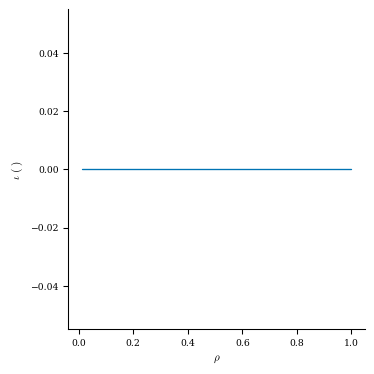

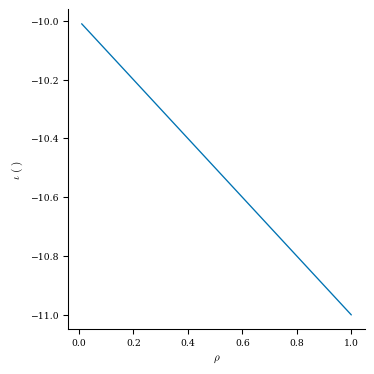

In [7]:
zero_current = PowerSeriesProfile(params=[0], modes=[0], grid=random_grid)
finite_current = PowerSeriesProfile(params=[1e7], modes=[2], grid=random_grid)
zero_current_torus = Equilibrium(current=zero_current)
finite_current_torus = Equilibrium(current=finite_current)

# linear grids for plotting
lin_grid_zero_torus = get_linear_grid(
    zero_current_torus, rho=random_grid.nodes[random_grid.unique_rho_indices, 0]
)
lin_grid_finite_torus = get_linear_grid(
    finite_current_torus, rho=random_grid.nodes[random_grid.unique_rho_indices, 0]
)

# plot_1d won't plot when linear grid (or any grid) is supplied ??
# does not plot the values in eq.compute(), probably because different grid
plot_1d(zero_current_torus, "iota")
print_grid(
    random_grid,
    stop=10,
    quantity=zero_current_torus.compute("iota", grid=lin_grid_zero_torus)["iota"],
)
print()
plot_1d(finite_current_torus, "iota")
print_grid(
    random_grid,
    stop=10,
    quantity=finite_current_torus.compute("iota", grid=lin_grid_finite_torus)["iota"],
)

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(


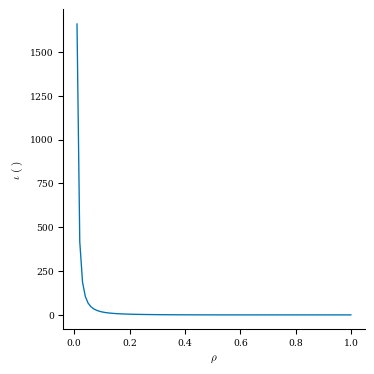

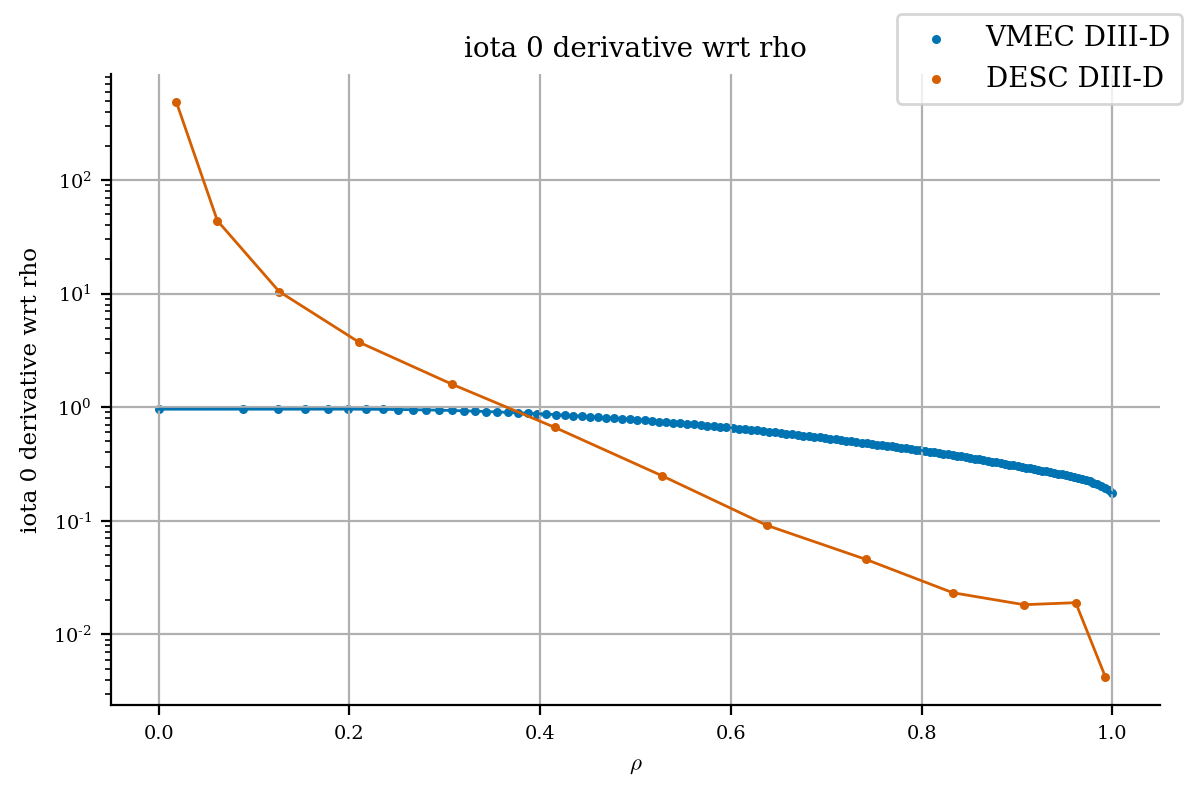

In [8]:
names = (
    # "ATF",
    # "DSHAPE",
    # "SOLOVEV",
    "DIII-D",
    # "HELIOTRON",
    # "AXISYM",
)

for name in names:
    eq = desc.io.load("../examples/DESC/input-current/" + name + "_output.h5")[-1]
    plot_1d(eq, "iota")

    rho, iota = get_vmec_plot(name)
    grid = get_concentric_grid(eq)
    iota_desc = eq.compute("iota", grid=grid)["iota"]
    plot_overlay(
        rho,
        iota,
        "VMEC " + name,
        grid.nodes[grid.unique_rho_indices, 0],
        iota_desc[grid.unique_rho_indices],
        "DESC " + name,
    )